# Predicción del riesgo crediticio

## 1. Análisis descriptivo y exploratorio de los datos

In [1]:
# Mostrar los datasets existentes
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings

# Ignorar warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

/kaggle/input/modelo-riesgo-crediticio/tensorflow2/default/1/modelo_riesgo_crediticio_final.h5
/kaggle/input/credit-risk-dataset/LCDataDictionary.xlsx
/kaggle/input/credit-risk-dataset/loan/loan.csv


In [2]:
# Análisis de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
    classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

# Red Neuronal con TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Utilidad para exportar el modelo
import joblib

# Utilidad para GridSearch
import itertools

# Verificación de GPU
print("TensorFlow versión:", tf.__version__)

2025-06-07 19:27:58.990775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749324479.177443      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749324479.232495      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow versión: 2.18.0


In [3]:
loan_df_raw = pd.read_csv(
    '/kaggle/input/credit-risk-dataset/loan/loan.csv',
    dtype={
        'desc': str,
        'verification_status_joint': str
    },
)

In [4]:
loan_df_raw.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Análisis de datos crudos

1. Tipos de variables

In [5]:
loan_df_raw.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Columns: 74 entries, id to inq_last_12m
dtypes: float64(49), int64(2), object(23)
memory usage: 501.0+ MB


2. Conteo de registros

In [6]:
loan_df_raw.shape

(887379, 74)

3. Valores faltantes

In [7]:
nan_proportion = loan_df_raw.isna().mean()
top_nan_proportion_cols = nan_proportion[nan_proportion > 0.2].sort_values(ascending=False)
print("Columns with highest proportion of NaNs:\n", top_nan_proportion_cols)

Columns with highest proportion of NaNs:
 dti_joint                      0.999426
annual_inc_joint               0.999424
verification_status_joint      0.999424
il_util                        0.979020
mths_since_rcnt_il             0.976549
open_il_6m                     0.975916
total_bal_il                   0.975916
open_rv_12m                    0.975916
open_rv_24m                    0.975916
max_bal_bc                     0.975916
all_util                       0.975916
open_il_12m                    0.975916
open_il_24m                    0.975916
open_acc_6m                    0.975916
total_cu_tl                    0.975916
inq_fi                         0.975916
inq_last_12m                   0.975916
desc                           0.857980
mths_since_last_record         0.845553
mths_since_last_major_derog    0.750160
mths_since_last_delinq         0.511971
next_pymnt_d                   0.285077
dtype: float64


4. Outliers y valores únicos

In [8]:
# Copia de trabajo
df = loan_df_raw.copy()

# Columnas categóricas y de fecha
categorical_cols = [
    'addr_state', 'application_type', 'grade', 'home_ownership',
    'initial_list_status', 'purpose', 'pymnt_plan', 'term',
    'verified_status_joint', 'is_inc_v', 'desc', 'emp_title', 'title'
]

date_cols = [
    'issue_d', 'last_credit_pull_d', 'next_pymnt_d', 'last_pymnt_d', 'earliest_cr_line'
]

# Rangos esperados
num_range_expected = {
    'fico_range_low': (300, 850),
    'fico_range_high': (300, 850),
    'last_fico_range_low': (300, 850),
    'last_fico_range_high': (300, 850),
    'int_rate': (0, 100),
    'revol_util': (0, 300),
    'il_util': (0, 300),
    'all_util': (0, 300),
    'emp_length': (0, 10),
    'term': (36, 60)
}

# Columnas donde no se esperan negativos
no_neg_expected = [
    col for col in df.columns 
    if col not in categorical_cols + date_cols and df[col].dtype in ['float64', 'int64']
]

# Listas de columnas con problemas
cols_negativos = []
cols_fuera_rango = []
cols_outliers = []
cols_fechas_futuras = []
cols_cardinalidad_alta = []

# Validación numérica
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    if col in no_neg_expected and (df[col] < 0).sum() > 0:
        cols_negativos.append(col)

    if col in num_range_expected:
        min_val, max_val = num_range_expected[col]
        if ((df[col] < min_val) | (df[col] > max_val)).any():
            cols_fuera_rango.append(col)

    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = df[(df[col] < q1 - 1.5 * iqr) | (df[col] > q3 + 1.5 * iqr)]
    if not outliers.empty:
        cols_outliers.append(col)

# Fechas futuras sospechosas
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        if df[col].max() > pd.to_datetime("today") + pd.Timedelta(days=30):
            cols_fechas_futuras.append(col)

# Alta cardinalidad
for col in df.select_dtypes(include='object').columns:
    if df[col].nunique() > 100:
        cols_cardinalidad_alta.append(col)

# Salida final
print("Columnas con valores negativos no esperados:\n", cols_negativos)
print("\nColumnas con valores fuera de rango esperado:\n", cols_fuera_rango)
print("\nNúmero de columnas con outliers:", len(cols_outliers))
print("\nColumnas con fechas atípicas:", len(cols_fechas_futuras))
print("\nColumnas con alta cardinalidad:\n", cols_cardinalidad_alta)

Columnas con valores negativos no esperados:
 ['inq_last_12m']

Columnas con valores fuera de rango esperado:
 ['revol_util']

Número de columnas con outliers: 44

Columnas con fechas atípicas: 0

Columnas con alta cardinalidad:
 ['emp_title', 'url', 'desc', 'title', 'zip_code']


In [9]:
df[['all_util', 'il_util', 'revol_util']].max()

all_util      151.4
il_util       223.3
revol_util    892.3
dtype: float64

In [10]:
df['revol_util'].sort_values(ascending=False).head(5)

406516    892.3
368206    366.6
671388    193.0
880908    184.6
574398    182.8
Name: revol_util, dtype: float64

Distribución de los tipos de préstamos (Individuales y conjuntos)

In [11]:
loan_df_raw['application_type'].value_counts(normalize=True)

application_type
INDIVIDUAL    0.999424
JOINT         0.000576
Name: proportion, dtype: float64

- Se identificó una alta proporción de valores nulos en varias columnas. Debido a esto, algunas variables podrían ser descartadas por no aportar valor significativo al modelo, especialmente en el caso de una red neuronal.

- La proporción de préstamos conjuntos en el conjunto de datos es muy baja, por lo que esta variable fue considerada irrelevante para el análisis y se decidió eliminarla.

- Se detectaron numerosos datos atípicos. Sin embargo, tras un análisis detallado, se concluyó que la mayoría de estos valores representaban situaciones posibles o razonables, por lo que no se eliminaron de forma masiva. En cambio, se optó por aplicar técnicas de escalamiento apropiadas para mitigar su impacto en el modelo.

- Después de aplicar esta primera etapa, se conservaron 886,875 observaciones con un total de 74 variables (features) listas para ser utilizadas en el entrenamiento del modelo.

#### 2. Análisis antes de feature engineering:

1. Estadísticas descriptivas básicas

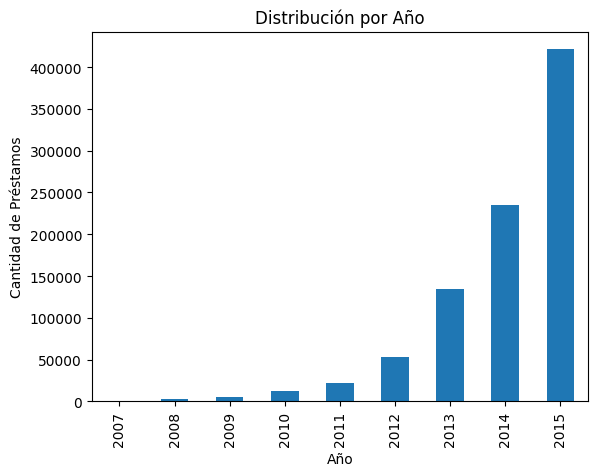

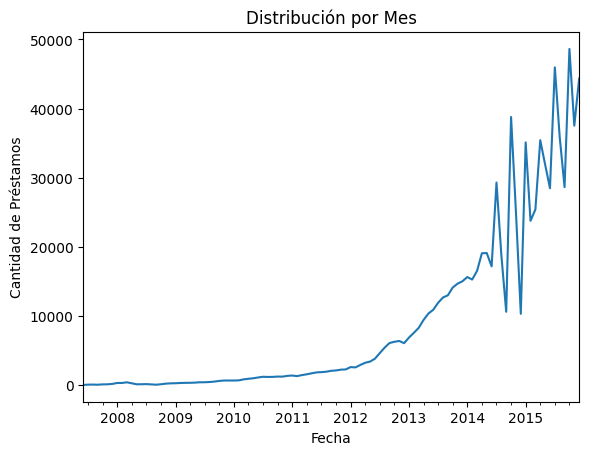

In [12]:
df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')

# Año
df['issue_d'].dt.year.value_counts().sort_index().plot(kind='bar', title='Distribución por Año')
plt.xlabel('Año'); plt.ylabel('Cantidad de Préstamos'); plt.show()

# Año-Mes
df['issue_d'].dt.to_period('M').value_counts().sort_index().plot(kind='line', title='Distribución por Mes')
plt.xlabel('Fecha'); plt.ylabel('Cantidad de Préstamos'); plt.show()

Podemos escoger el mes para tomar los datos más granulares

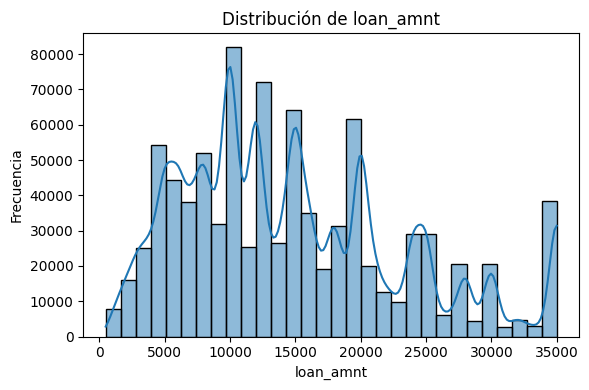

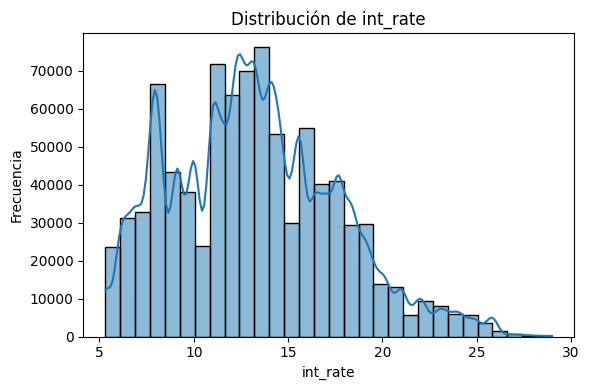

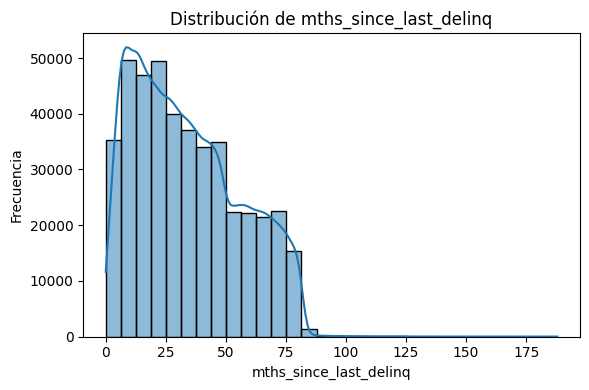

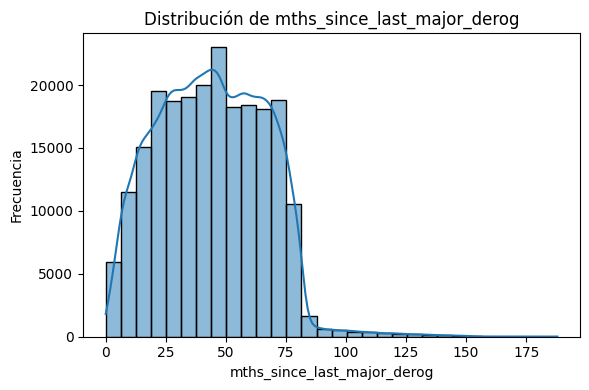

In [13]:
key_numeric = ['loan_amnt', 'int_rate','mths_since_last_delinq', 'mths_since_last_major_derog']

for col in key_numeric:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

Estas gráficas indican información muy importante sobre las distribuciones de las columnas numéricas

- Las variables de delinq y derog indican si un cliente es incumplido. Los valores NaN indican que no hay incumplimiento y por tanto debemos limpiar bien estas columnas o escoger una codificación binaria para ambas.

- Distribución multimodal de cantidad de préstamo: Se observan varios picos, lo que indica que los montos no son continuos, sino que hay valores comunes o predeterminados (como 5k, 10k, 15k, etc.), probablemente definidos por políticas de la entidad financiera.

Corte abrupto en 35,000: Puede indicar un límite superior permitido por el producto de préstamo.

- La mayoría de los préstamos tienen tasas entre 8% y 16%, pero hay una cola larga que se extiende hasta casi 30%

In [14]:
# Crear una copia del DataFrame original
loan_df_clean_cols = loan_df_raw.copy()

In [15]:
loan_df_clean_cols = loan_df_clean_cols[loan_df_clean_cols['application_type'] == 'INDIVIDUAL']

### Limpieza de datos

In [16]:
# Definir columnas a eliminar (Basado en información anterior y el Diccionario del dataset)
cols_to_drop = [
    # Identificadores
    'id',
    'member_id',
    # > 95% NaNs
    'all_util','annual_inc_joint','dti_joint','il_util','inq_fi','inq_last_12m',
    'max_bal_bc','open_acc_6m','open_il_12m','open_il_24m','open_il_6m',
    'open_rv_12m','open_rv_24m','mths_since_rcnt_il','total_bal_il',
    'total_cu_tl','verification_status_joint',
    # Texto libre
    'desc','url',
    # Valores Futuros al Préstamo
    'mths_since_last_record','next_pymnt_d',
    # Alta cardinalidad
    'emp_title','title', 'zip_code',
    # Desbalance o Muy Baja Cardinalidad
    'policy_code',
    'application_type',
    'pymnt_plan',
    # Hay una mejor columna
    'grade', # sub_grade es más granular
    # Explican lo mismo que loan_amnt (Altísima Correlación)
    'funded_amnt', 'funded_amnt_inv',
    # Data Leakage (No disponibles antes de predecir)
    'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
    'recoveries',
    'last_pymnt_d', 'last_credit_pull_d',
    'out_prncp', 'out_prncp_inv',
    'total_pymnt', 'total_pymnt_inv',
    'recoveries',
    'collection_recovery_fee',
    'last_pymnt_amnt',
]

# Eliminar columnas
loan_df_clean_cols = loan_df_clean_cols.drop(columns=cols_to_drop)

# Eliminar solo los valores extremadamente altos (posibles errores)
loan_df_clean_cols = loan_df_clean_cols[loan_df_clean_cols['revol_util'] < 200]

### Ingeniería de Features

In [17]:
loan_df_feature_eng = loan_df_clean_cols.copy()

In [18]:
loan_df_feature_eng.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim'],
      dtype='object')

In [19]:
# issue-d como datetime
loan_df_feature_eng['issue_d'] = pd.to_datetime(loan_df_feature_eng['issue_d'], format='%b-%Y')

# Extrae mes como columna separada
loan_df_feature_eng['issue_month'] = loan_df_feature_eng['issue_d'].dt.month

In [20]:
# Extraer componentes cíclicos del préstamo
loan_df_feature_eng['issue_month_sin'] = np.sin(2 * np.pi * loan_df_feature_eng['issue_month'] / 12)
loan_df_feature_eng['issue_month_cos'] = np.cos(2 * np.pi * loan_df_feature_eng['issue_month'] / 12)
loan_df_feature_eng = loan_df_feature_eng.drop('issue_month', axis=1)

In [21]:
# Convertimos earliest_cr_line a datetime
loan_df_feature_eng['earliest_cr_line'] = pd.to_datetime(loan_df_feature_eng['earliest_cr_line'], format='%b-%Y', errors='coerce')

# Calculamos antigüedad crediticia en años
loan_df_feature_eng['credit_history_length'] = (loan_df_feature_eng['issue_d'] - loan_df_feature_eng['earliest_cr_line']).dt.days / 365

In [22]:
# Ya que las transformamos, eliminamos las columnas originales
loan_df_feature_eng = loan_df_feature_eng.drop(columns=['issue_d', 'earliest_cr_line'])

In [23]:
nan_proportion_feature_eng = loan_df_feature_eng.isna().mean()
top_nan_proportion_feature_eng = nan_proportion_feature_eng[nan_proportion_feature_eng > 0].sort_values(ascending=False)
print("Columns with highest proportion of NaNs:\n", top_nan_proportion_feature_eng)

Columns with highest proportion of NaNs:
 mths_since_last_major_derog    0.750210
mths_since_last_delinq         0.512046
tot_coll_amt                   0.079149
tot_cur_bal                    0.079149
total_rev_hi_lim               0.079149
emp_length                     0.050486
collections_12_mths_ex_med     0.000127
dtype: float64


In [24]:
loan_df_feature_eng[['mths_since_last_major_derog', 'mths_since_last_delinq']].isna().mean()

mths_since_last_major_derog    0.750210
mths_since_last_delinq         0.512046
dtype: float64

In [25]:
loan_df_feature_eng[['mths_since_last_major_derog', 'mths_since_last_delinq']].describe()

,mths_since_last_major_derog,mths_since_last_delinq
count,221405.000000,432505.000000
mean,44.110702,34.068989
std,22.181373,21.886684
min,0.000000,0.000000
25%,27.000000,15.000000
50%,44.000000,31.000000
75%,61.000000,50.000000
max,188.000000,188.000000


In [26]:
# Crear flags binarios

# Hay dos modelos

#loan_df_clean_cols['has_major_derog'] = loan_df_clean_cols['mths_since_last_major_derog'].notna().astype(int)
#loan_df_clean_cols['has_delinq'] = loan_df_clean_cols['mths_since_last_delinq'].notna().astype(int)

# Imputar con un valor alto que represente "nunca ha tenido"
# Puedes usar 999 o el máximo valor + algo
#loan_df_clean_cols['mths_since_last_major_derog'] = loan_df_clean_cols['mths_since_last_major_derog'].fillna(999)
#loan_df_clean_cols['mths_since_last_delinq'] = loan_df_clean_cols['mths_since_last_delinq'].fillna(999)

In [27]:
# Crear solo las variables binarias y eliminar las originales
loan_df_feature_eng['has_major_derog'] = loan_df_feature_eng['mths_since_last_major_derog'].notna().astype(int)
loan_df_feature_eng['has_delinq'] = loan_df_feature_eng['mths_since_last_delinq'].notna().astype(int)

# Eliminar las columnas originales
loan_df_feature_eng = loan_df_feature_eng.drop(columns=['mths_since_last_major_derog', 'mths_since_last_delinq'])

In [28]:
nan_proportion_feature_eng = loan_df_feature_eng.isna().mean()
top_nan_proportion_feature_eng = nan_proportion_feature_eng[nan_proportion_feature_eng > 0].sort_values(ascending=False)
print("Columns with highest proportion of NaNs:\n", top_nan_proportion_feature_eng)

Columns with highest proportion of NaNs:
 tot_coll_amt                  0.079149
total_rev_hi_lim              0.079149
tot_cur_bal                   0.079149
emp_length                    0.050486
collections_12_mths_ex_med    0.000127
dtype: float64


In [29]:
# Ver distribuciones de las variables con pocos NaNs
numeric_cols = ['tot_coll_amt', 
                'tot_cur_bal', 
                'total_rev_hi_lim', 
                'emp_length', 
                'revol_util', 
                'collections_12_mths_ex_med', 
                'delinq_2yrs',
                'inq_last_6mths',
                'open_acc',
                'pub_rec',
                'total_acc',
                'acc_now_delinq',
                'credit_history_length',
                'annual_inc']

for col in numeric_cols:
    print(f"\n{col}:")
    print(loan_df_feature_eng[col].describe())
    print(f"% NaN: {loan_df_feature_eng[col].isna().mean()*100:.2f}%")


tot_coll_amt:
count    8.162090e+05
mean     2.257335e+02
std      1.031693e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.152545e+06
Name: tot_coll_amt, dtype: float64
% NaN: 7.91%

tot_cur_bal:
count    8.162090e+05
mean     1.394103e+05
std      1.537060e+05
min      0.000000e+00
25%      2.984600e+04
50%      8.050900e+04
75%      2.081390e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64
% NaN: 7.91%

total_rev_hi_lim:
count    8.162090e+05
mean     3.208128e+04
std      3.750083e+04
min      0.000000e+00
25%      1.400000e+04
50%      2.370000e+04
75%      3.980000e+04
max      9.999999e+06
Name: total_rev_hi_lim, dtype: float64
% NaN: 7.91%

emp_length:
count        841615
unique           11
top       10+ years
freq         291250
Name: emp_length, dtype: object
% NaN: 5.05%

revol_util:
count    886364.000000
mean         55.061851
std          23.815749
min           0.000000
25%          37.700000
50%        

In [30]:
# Flags para columnas con significancia en el "missingness"
loan_df_feature_eng['has_coll_amt'] = loan_df_feature_eng['tot_coll_amt'].notna().astype(int)
loan_df_clean_cols['has_cur_bal'] = loan_df_feature_eng['tot_cur_bal'].notna().astype(int)
loan_df_clean_cols['has_rev_hi_lim'] = loan_df_feature_eng['total_rev_hi_lim'].notna().astype(int)

# Imputación
loan_df_feature_eng['tot_coll_amt'].fillna(0, inplace=True)

# Usa la mediana para evitar sesgos por outliers
loan_df_feature_eng['tot_cur_bal'].fillna(loan_df_feature_eng['tot_cur_bal'].median(), inplace=True)
loan_df_feature_eng['total_rev_hi_lim'].fillna(loan_df_feature_eng['total_rev_hi_lim'].median(), inplace=True)

# Revolving utilization (muy pocos NaNs)
loan_df_feature_eng['revol_util'].fillna(loan_df_feature_eng['revol_util'].median(), inplace=True)

# Cobros no médicos últimos 12 meses (altamente esparsa)
loan_df_feature_eng['collections_12_mths_ex_med'].fillna(0, inplace=True)

In [31]:
nan_proportion_feature_eng = loan_df_feature_eng.isna().sum()
top_nan_proportion_feature_eng = nan_proportion_feature_eng[nan_proportion_feature_eng > 0].sort_values(ascending=False)
print("Columns with highest proportion of NaNs:\n", top_nan_proportion_feature_eng)

Columns with highest proportion of NaNs:
 emp_length    44749
dtype: int64


Clases predictoras con altos desbalances

In [32]:
for col in loan_df_feature_eng.columns:
    if (loan_df_feature_eng[col].value_counts(normalize=True) > 0.75).any():
        print(f'Desbalance en {col}')

Desbalance en delinq_2yrs
Desbalance en pub_rec
Desbalance en collections_12_mths_ex_med
Desbalance en acc_now_delinq
Desbalance en tot_coll_amt
Desbalance en has_major_derog
Desbalance en has_coll_amt


In [33]:
loan_df_feature_eng['delinq_2yrs'] = (loan_df_feature_eng['delinq_2yrs'] > 0).astype(int)
loan_df_feature_eng['pub_rec'] = (loan_df_feature_eng['pub_rec'] > 0).astype(int)
loan_df_feature_eng['collections_12_mths_ex_med'] = (loan_df_feature_eng['collections_12_mths_ex_med'] > 0).astype(int)
loan_df_feature_eng['acc_now_delinq'] = (loan_df_feature_eng['acc_now_delinq'] > 0).astype(int)
loan_df_feature_eng['tot_coll_amt'] = (loan_df_feature_eng['tot_coll_amt'] > 0).astype(int)

In [34]:
loan_df_feature_eng.shape

(886364, 32)

### Mapping de la variable objetivo

Análisis antes del mapping de la variable objetivo:

Visualizar distribución de variables según clases (target) o grupos relevantes.
Tiempo estimado: 6 horas

Explorar categorías originales del target (loan_status).

Evaluar balance de clases y relación con variables predictoras.
Tiempo estimado: 2 horas

In [35]:
loan_df_mapped = loan_df_feature_eng.copy()

In [36]:
mapping = {
    # Buenos pagadores (0)
    'Fully Paid': 0,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    
    # Malos pagadores (1)
    'Charged Off': 1,
    'Default': 1,
    'Does not meet the credit policy. Status:Charged Off': 1,
    'Late (31-120 days)': 1,
    
    # Casos inciertos (NaN)
    'Current': np.nan,
    'Issued': np.nan, 
    'In Grace Period': np.nan,
    'Late (16-30 days)': np.nan,
}

In [37]:
# Ver valores únicos
print("Valores únicos en loan_status:")
print(loan_df_mapped['loan_status'].value_counts())

# Aplicar el mapeo completo
loan_df_mapped['loan_status_bin'] = loan_df_mapped['loan_status'].map(mapping)
loan_df_mapped = loan_df_mapped.dropna(subset=['loan_status_bin'])

# Verificar que no haya valores no mapeados
unmapped = loan_df_mapped[loan_df_mapped['loan_status_bin'].isna() & 
                               loan_df_mapped['loan_status'].notna()]
if len(unmapped) > 0:
    print("Valores no mapeados:")
    print(unmapped['loan_status'].value_counts())

loan_df_mapped = loan_df_mapped.drop(columns=['loan_status'])

Valores únicos en loan_status:
loan_status
Current                                                601092
Fully Paid                                             207569
Charged Off                                             45201
Late (31-120 days)                                      11580
Issued                                                   8393
In Grace Period                                          6247
Late (16-30 days)                                        2355
Does not meet the credit policy. Status:Fully Paid       1954
Default                                                  1218
Does not meet the credit policy. Status:Charged Off       755
Name: count, dtype: int64


In [38]:
cols_with_low_missing = [
    'revol_util', 
    'collections_12_mths_ex_med', 
    'delinq_2yrs',
    'inq_last_6mths',
    'open_acc',
    'pub_rec',
    'total_acc',
    'acc_now_delinq',
    'credit_history_length',
    'annual_inc'
]

correlations = loan_df_mapped[cols_with_low_missing + ['loan_status_bin']].corr()['loan_status_bin'].sort_values(ascending=False)

In [39]:
correlations

loan_status_bin               1.000000
revol_util                    0.100432
inq_last_6mths                0.053439
delinq_2yrs                   0.028882
open_acc                      0.022992
collections_12_mths_ex_med    0.018870
pub_rec                       0.013619
acc_now_delinq                0.012114
credit_history_length        -0.017737
total_acc                    -0.028029
annual_inc                   -0.056527
Name: loan_status_bin, dtype: float64

In [40]:
loan_df_mapped.dropna(subset=cols_with_low_missing, inplace=True)

In [41]:
nan_proportion_mapped = loan_df_mapped.isna().sum()
top_nan_proportion_feature_eng = nan_proportion_mapped[nan_proportion_mapped > 0].sort_values(ascending=False)
print("Columns with highest proportion of NaNs:\n", top_nan_proportion_feature_eng)

Columns with highest proportion of NaNs:
 emp_length    10713
dtype: int64


In [42]:
loan_df_mapped.isna().any().any()

True

In [43]:
loan_df_mapped.shape

(268277, 32)

### Limpieza de Strings

In [44]:
loan_df_clean_categorical = loan_df_mapped.copy()

In [45]:
loan_df_clean_categorical.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,...,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,issue_month_sin,issue_month_cos,credit_history_length,has_major_derog,has_delinq,has_coll_amt,loan_status_bin
0,5000.0,36 months,10.65,162.87,B2,10+ years,RENT,24000.0,Verified,credit_card,...,0,80509.0,23700.0,-2.449294e-16,1.0,26.931507,0,0,0,0.0
1,2500.0,60 months,15.27,59.83,C4,< 1 year,RENT,30000.0,Source Verified,car,...,0,80509.0,23700.0,-2.449294e-16,1.0,12.676712,0,0,0,1.0
2,2400.0,36 months,15.96,84.33,C5,10+ years,RENT,12252.0,Not Verified,small_business,...,0,80509.0,23700.0,-2.449294e-16,1.0,10.087671,0,0,0,0.0
3,10000.0,36 months,13.49,339.31,C1,10+ years,RENT,49200.0,Source Verified,other,...,0,80509.0,23700.0,-2.449294e-16,1.0,15.841096,0,1,0,0.0
5,5000.0,36 months,7.90,156.46,A4,3 years,RENT,36000.0,Source Verified,wedding,...,0,80509.0,23700.0,-2.449294e-16,1.0,7.084932,0,0,0,0.0


In [46]:
loan_df_clean_categorical.select_dtypes(include='int').head()

,delinq_2yrs,pub_rec,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,has_major_derog,has_delinq,has_coll_amt
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0


In [47]:
ordered_sub_grades = [f"{l}{n}" for l in 'ABCDEFG' for n in range(1, 6)]

# Paso 2: Crear diccionario de mapeo
sub_grade_map = {grade: i for i, grade in enumerate(ordered_sub_grades)}

# Paso 3: Mapear la columna
loan_df_clean_categorical['sub_grade'] = loan_df_clean_categorical['sub_grade'].map(sub_grade_map)

In [48]:
loan_df_clean_categorical['emp_length'] = loan_df_clean_categorical['emp_length'].fillna('Unknown')

In [49]:
loan_df_clean_categorical.select_dtypes(include='object').head()

,term,emp_length,home_ownership,verification_status,purpose,addr_state,initial_list_status
0,36 months,10+ years,RENT,Verified,credit_card,AZ,f
1,60 months,< 1 year,RENT,Source Verified,car,GA,f
2,36 months,10+ years,RENT,Not Verified,small_business,IL,f
3,36 months,10+ years,RENT,Source Verified,other,CA,f
5,36 months,3 years,RENT,Source Verified,wedding,AZ,f


In [50]:
loan_df_clean_categorical.shape

(268277, 32)

## 2. EDA

Después de la limpieza y de múltiples transformaciones, vamos a analizar el dataset resultante, diagnosticar posibles problemas que enfrentaría la red y crear hipótesis sobre esta.

Análisis descriptivo y visualización inicial:

Graficar distribuciones, correlaciones, y variables más relevantes.

Generar reportes parciales con insights y posibles variables riesgosas.
Tiempo estimado: 6 horas

Registrar hipótesis, resultados y conclusiones del análisis exploratorio en reporte técnico.
Tiempo estimado: 4 horas

In [51]:
loan_df_eda = loan_df_clean_categorical.copy()

In [52]:
loan_df_eda.shape

(268277, 32)

Para asegurar la calidad y relevancia del conjunto de datos, se eliminaron ciertas filas que contenían valores inciertos o estados de préstamo que no aportan información definitiva sobre el resultado del préstamo. En concreto, se descartaron los siguientes casos:

 Filas con valores faltantes (NaN).

 Préstamos con estado 'Current', que indican préstamos activos sin información definitiva de pago o incumplimiento.

  Préstamos en estado 'Issued', que aún no han iniciado el ciclo de pago.

  Préstamos en 'In Grace Period', que están en un período de gracia antes de una posible mora.

  Préstamos con pagos 'Late (16-30 days)', que aún podrían regularizarse.

La eliminación de estas categorías elimina filas que no contribuyen a la clasificación clara del estado final del préstamo. Esto reduce significativamente el tamaño del conjunto de datos, de 887,379 a 268,277 filas, es decir, una reducción aproximada del 70%.

Este proceso es fundamental para centrarse en casos con resultados claros y definitivos, mejorando la calidad del entrenamiento y la interpretabilidad del modelo predictivo.

In [53]:
loan_df_eda.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'collections_12_mths_ex_med', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'issue_month_sin',
       'issue_month_cos', 'credit_history_length', 'has_major_derog',
       'has_delinq', 'has_coll_amt', 'loan_status_bin'],
      dtype='object')

#### Análisis univariado

**Revisión de balance de clases**

A pesar de haber hecho feature engineering para reducir los desbalances de clases todavía tenemos las siguientes columnas con desbalances significativos:

In [54]:
for col in loan_df_eda.columns:
    if (loan_df_eda[col].value_counts(normalize=True) > 0.75).any():
        print(f'Desbalance en {col}')

Desbalance en term
Desbalance en delinq_2yrs
Desbalance en pub_rec
Desbalance en collections_12_mths_ex_med
Desbalance en acc_now_delinq
Desbalance en tot_coll_amt
Desbalance en has_major_derog
Desbalance en has_coll_amt
Desbalance en loan_status_bin


In [55]:
loan_df_eda['loan_status_bin'].value_counts(normalize=True)

loan_status_bin
0.0    0.780995
1.0    0.219005
Name: proportion, dtype: float64

Este desbalance de clases será un punto muy importante a tener en cuenta a la hora de hacer el entrenamiento, ya que puede afectar significativamente el desempeño del modelo. En particular, la clase negativa (0.0) con 209,523 instancias es mucho más grande que la clase positiva (1.0) con 58,754 instancias, lo que puede causar que el modelo tienda a favorecer la clase mayoritaria y tenga dificultades para identificar correctamente la clase minoritaria.

Por ello, será necesario aplicar técnicas para manejar este desbalance, tales como:

- Uso de métricas adecuadas que consideren el desbalance (como AUC-ROC, F1-score, recall).

- Técnicas de muestreo, como sobremuestreo de la clase minoritaria o submuestreo de la clase mayoritaria.

- Ajuste de umbrales de decisión para mejorar la sensibilidad hacia la clase minoritaria.

Abordar este desbalance permite construir un modelo justo y efectivo, especialmente en problemas donde la detección correcta de la clase minoritaria (por ejemplo, préstamos en incumplimiento) tiene un impacto crítico.

**Revisión de variables numéricas continuas**

In [56]:
continuas = [
    'loan_amnt',
    'int_rate',
    'installment',
    'dti',
    'open_acc',
    'credit_history_length',
    'revol_util',
    'total_acc',
]

continuas_biased = [  
    'total_rev_hi_lim',
    'annual_inc',
    'inq_last_6mths',
    'revol_bal',
    'tot_cur_bal',
]

In [57]:
def plot_multiple_violins_iqr(data, columns):
    """
    Muestra violin plots en un grid de 2 columnas con IQR visible para múltiples columnas continuas.

    Parámetros:
    - data: DataFrame con los datos.
    - columns: Lista de nombres de columnas a graficar.
    """
    n = len(columns)
    ncols = 2
    nrows = n // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 4 * nrows))

    # Asegura que axes sea 2D
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.violinplot(y=data[col], inner="quartile", linewidth=1, color='skyblue', ax=axes[i])
        axes[i].set_title(f'Violin plot de {col} con IQR')
        axes[i].set_xlabel('')
        axes[i].set_ylabel(col)

    # Oculta ejes vacíos si sobran
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

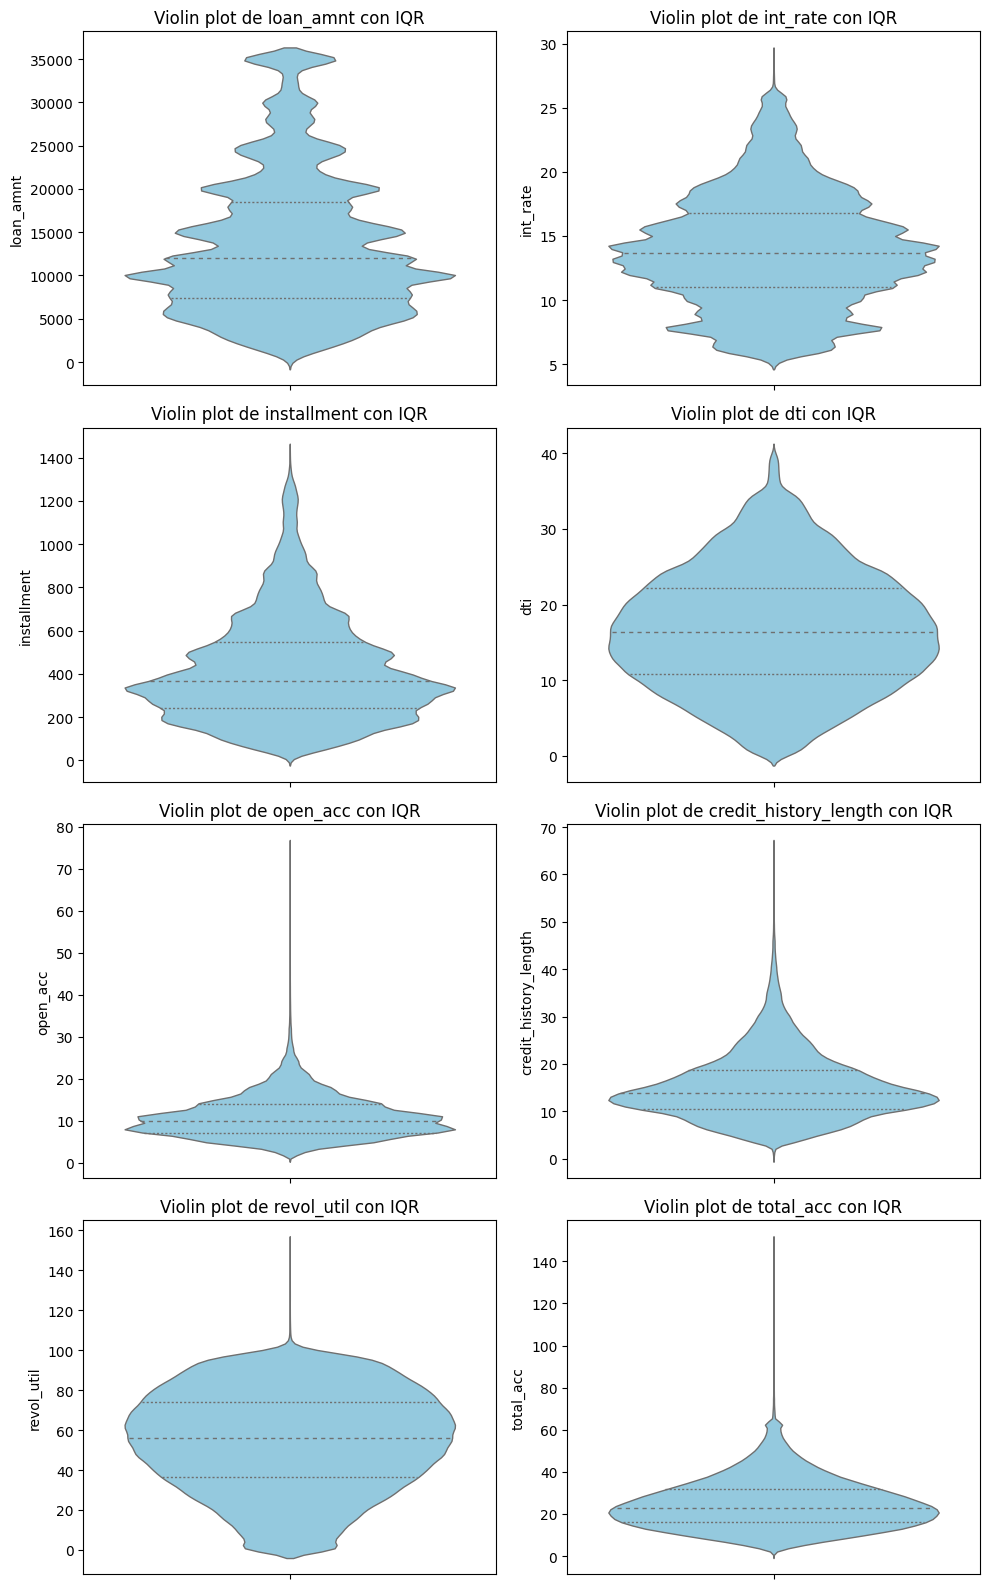

In [58]:
plot_multiple_violins_iqr(loan_df_eda, continuas)

In [59]:
def plot_violin_logscale(data, column):
    plt.figure(figsize=(4, 5))
    sns.violinplot(y=data[column], inner="quartile", color="skyblue")
    plt.yscale('log')
    plt.title(f'Violin plot log-scale de {column}')
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()

In [60]:
loan_df_eda[continuas_biased].describe()

,total_rev_hi_lim,annual_inc,inq_last_6mths,revol_bal,tot_cur_bal
count,2.682770e+05,2.682770e+05,268277.000000,2.682770e+05,2.682770e+05
mean,2.810380e+04,7.238645e+04,0.886453,1.531356e+04,1.230548e+05
std,2.572641e+04,5.842306e+04,1.155355,1.973950e+04,1.335055e+05
min,1.000000e+02,1.896000e+03,0.000000,0.000000e+00,0.000000e+00
25%,1.590000e+04,4.500000e+04,0.000000,5.855000e+03,3.800000e+04
50%,2.370000e+04,6.200000e+04,1.000000,1.092900e+04,8.050900e+04
75%,3.060000e+04,8.700000e+04,1.000000,1.909200e+04,1.637810e+05
max,2.013133e+06,8.706582e+06,33.000000,1.746716e+06,8.000078e+06


**Escalado de variables numéricas sesgadas y no sesgadas**

Para preparar los datos numéricos para el modelado, se pueden aplicar técnicas de escalado considerando la distribución y presencia de valores atípicos en las variables.

- **Variables altamente sesgadas con outliers extremos**, como `annual_inc`, `revol_bal`, `tot_cur_bal` y `total_rev_hi_lim`, fueron escaladas utilizando **RobustScaler**. Este método utiliza la mediana y el rango intercuartílico, por lo que es menos sensible a valores extremos y preserva la estructura de los datos sesgados.

- **Variables con distribución más cercana a la normalidad**, como `int_rate`, `installment`, `dti` y `inq_last_6mths`, se escalaron con **StandardScaler**, que centra y escala usando la media y desviación estándar.

Esta combinación permite una mejor normalización adaptada a cada variable, evitando que outliers influyan negativamente en el escalado y mejorando la estabilidad y rendimiento del modelo.

La implementación se realizó mediante un `ColumnTransformer` que aplica el escalado adecuado a cada grupo de variables.

**Revisión de Variables Categóricas**

In [61]:
variables_categoricas = [
    'term',
    'sub_grade',
    'emp_length',
    'home_ownership',
    'tot_coll_amt',
    'verification_status',
    'purpose',
    'initial_list_status',
    'addr_state',
]

In [62]:
def plot_categorical_summary(df, categorical_vars, target='loan_status_bin', max_unique=20):
    """
    Genera gráficos para resumir variables categóricas contra una variable binaria de objetivo.

    Parámetros:
    - df: DataFrame limpio.
    - categorical_vars: lista de nombres de columnas categóricas.
    - target: columna binaria (por defecto 'loan_status_bin').
    - max_unique: máximo de categorías únicas para graficar (evita sobrecarga visual).
    """
    for col in categorical_vars:
        plt.figure(figsize=(10, 5))
        if df[col].nunique() > max_unique:
            print(f"[Saltando] '{col}' tiene más de {max_unique} categorías únicas.")
            continue

        ax = sns.countplot(data=df, x=col, hue=target, palette='Set2', order=df[col].value_counts().index)
        total_counts = df[col].value_counts()

        plt.title(f"Distribución de '{col}' por '{target}'")
        plt.xticks(rotation=45)
        plt.xlabel(col)
        plt.ylabel("Conteo")
        plt.tight_layout()
        plt.show()

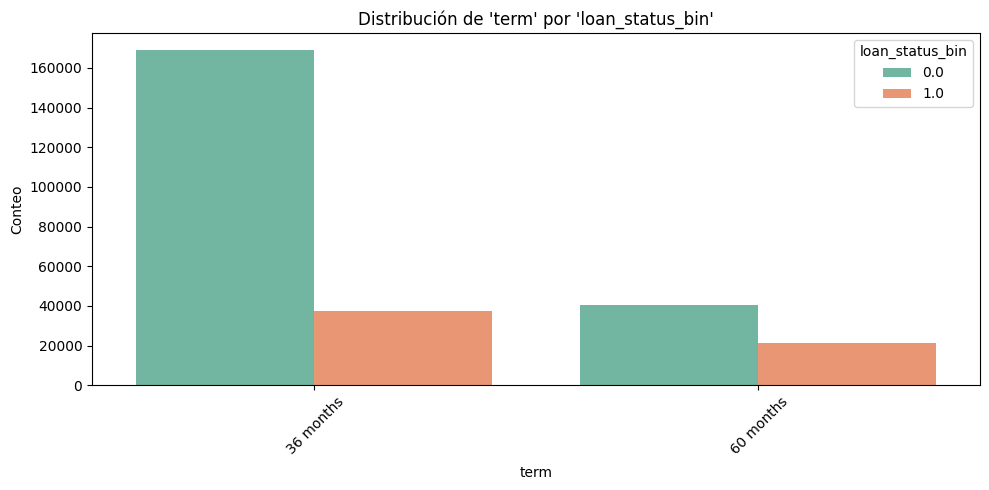

[Saltando] 'sub_grade' tiene más de 20 categorías únicas.


<Figure size 1000x500 with 0 Axes>

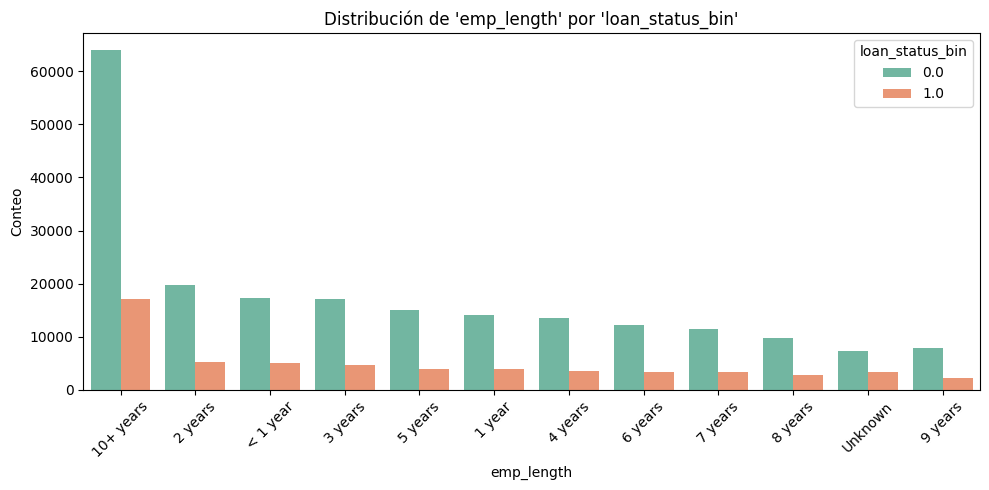

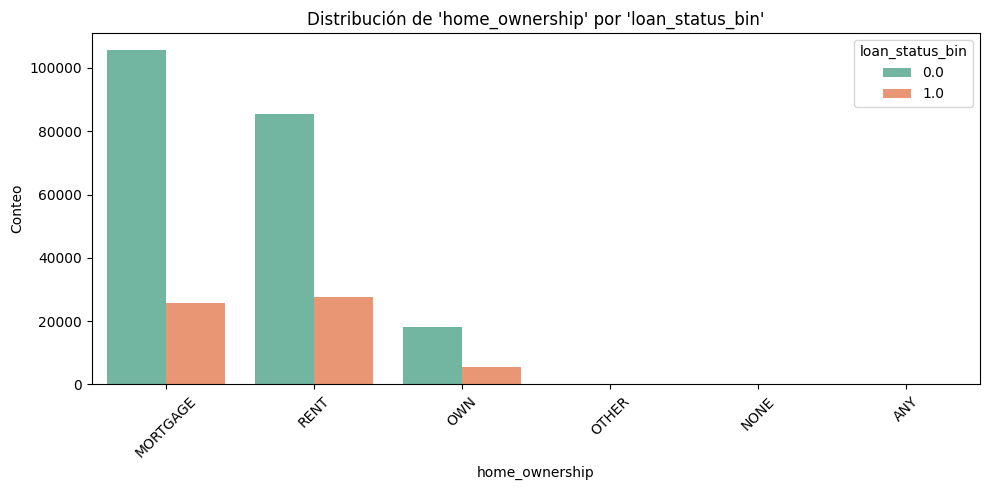

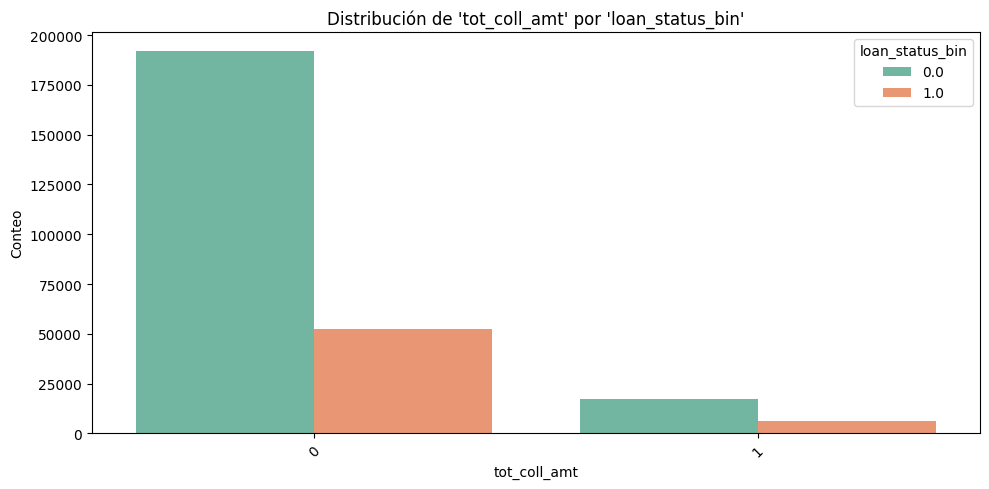

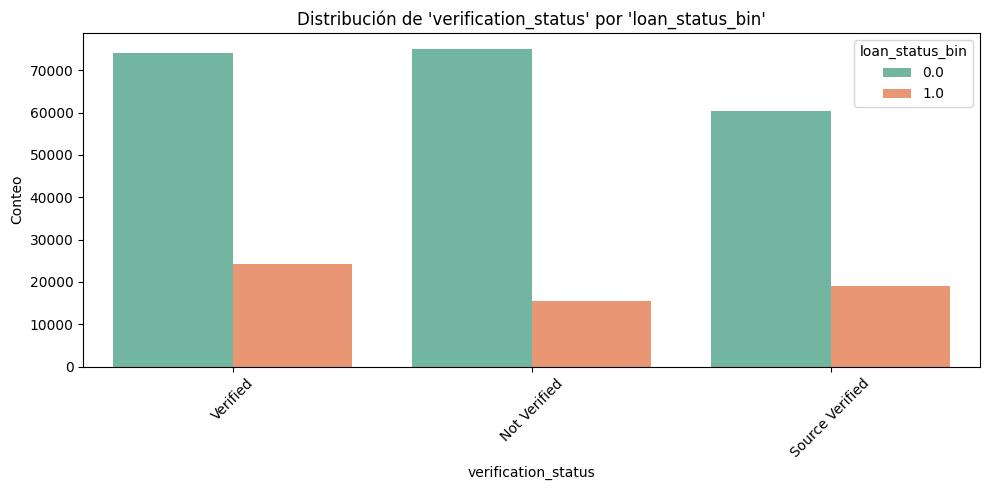

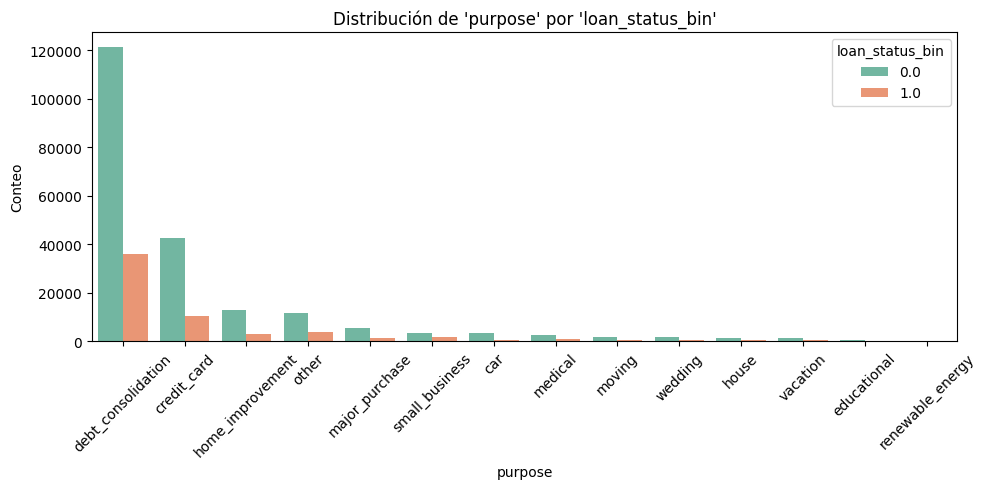

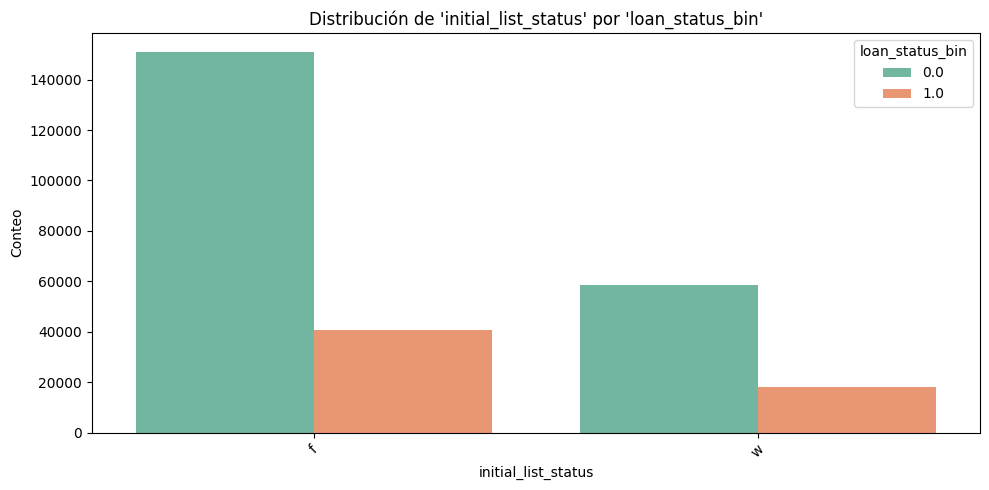

[Saltando] 'addr_state' tiene más de 20 categorías únicas.


<Figure size 1000x500 with 0 Axes>

In [63]:
plot_categorical_summary(loan_df_eda, variables_categoricas)

No hay patrones evidentes en cuanto a las variables categóricas

**Variables binarias**

In [64]:
variables_binarias = [
    'delinq_2yrs',
    'pub_rec',
    'collections_12_mths_ex_med',
    'acc_now_delinq',
    'has_major_derog',
    'has_delinq',
    'has_coll_amt',
]

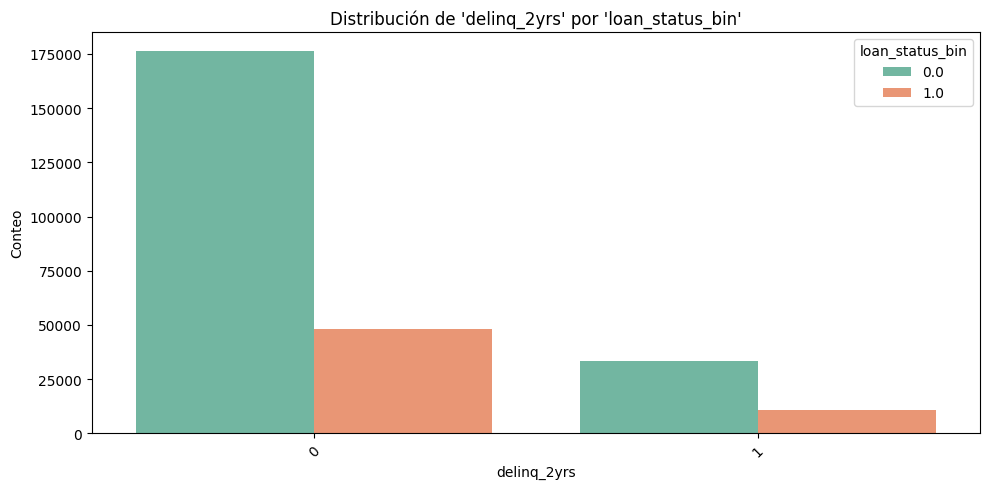

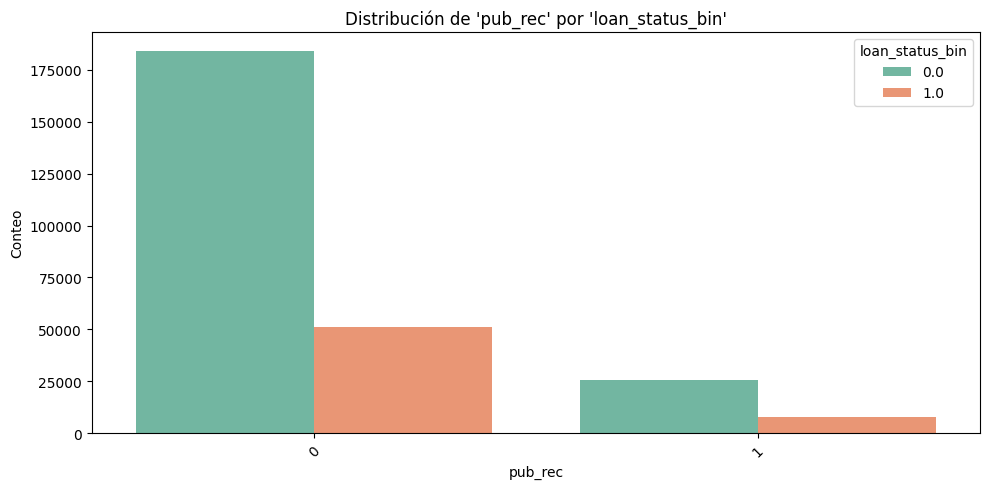

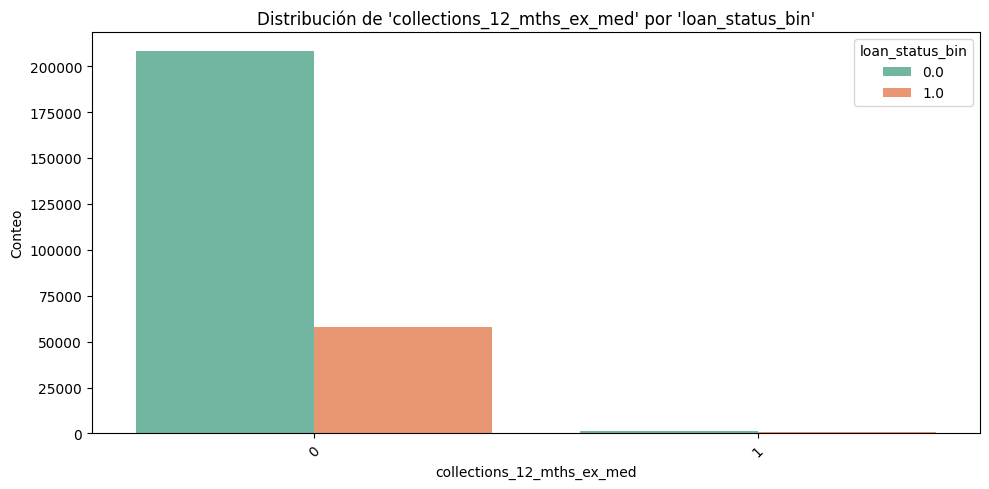

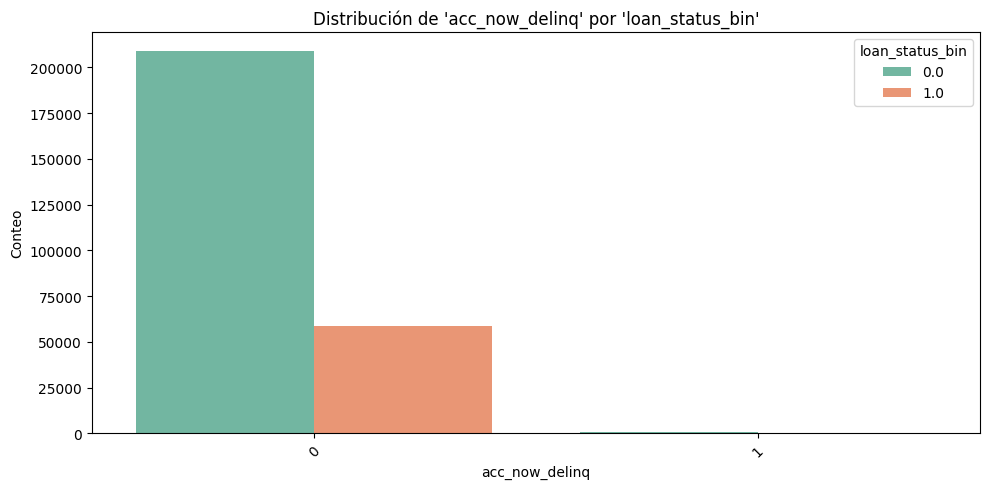

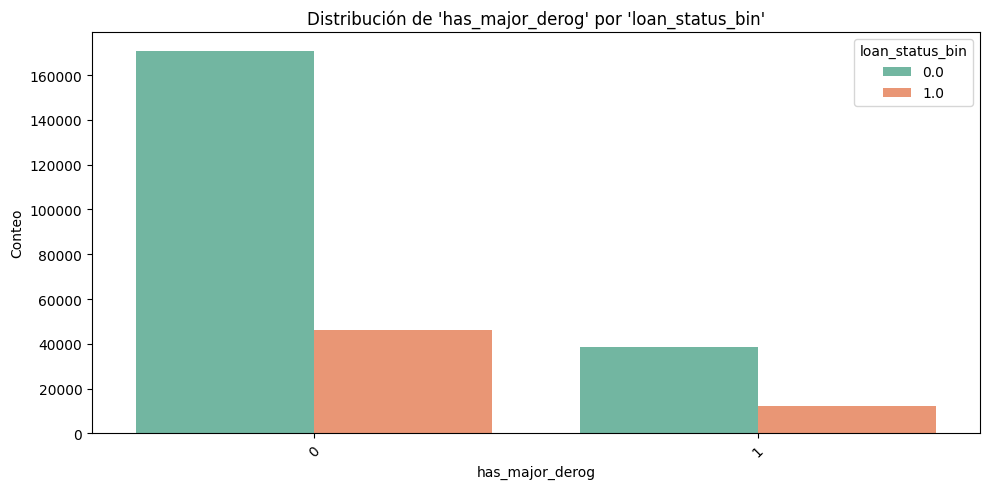

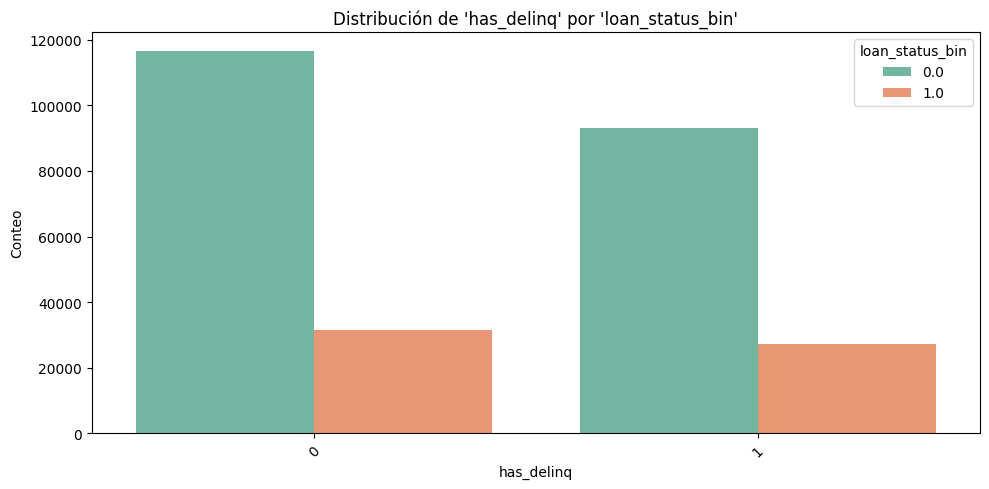

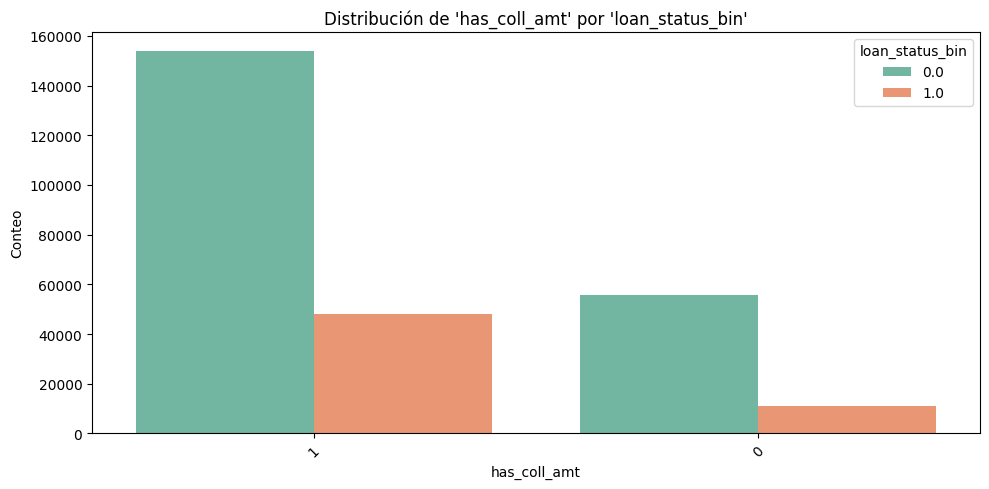

In [65]:
plot_categorical_summary(loan_df_eda, variables_binarias)

No hay hallazgos interesantes en las variables categóricas

#### Análisis Multivariado

In [66]:
loan_df_eda.groupby('sub_grade')['loan_status_bin'].mean().sort_values(ascending=False)

sub_grade
34    0.494585
32    0.490291
29    0.489927
30    0.480149
28    0.470414
31    0.469799
27    0.456684
26    0.423788
24    0.420231
25    0.412618
23    0.403504
33    0.401993
21    0.389343
22    0.388411
20    0.360053
19    0.346017
18    0.338838
17    0.303442
16    0.302664
15    0.289042
14    0.274297
13    0.260229
12    0.244119
11    0.216842
10    0.201677
9     0.180526
8     0.166012
7     0.145128
6     0.131544
5     0.121297
4     0.099250
3     0.080818
2     0.065849
1     0.055724
0     0.035926
Name: loan_status_bin, dtype: float64

In [67]:
loan_df_eda.groupby(['purpose', 'home_ownership'])['loan_status_bin'].mean().unstack()

home_ownership,ANY,MORTGAGE,NONE,OTHER,OWN,RENT
purpose,,,,,,
car,NaN,0.102580,NaN,0.333333,0.135440,0.182670
credit_card,NaN,0.170328,0.153846,0.190476,0.217631,0.214992
debt_consolidation,0.0,0.206391,0.250000,0.258065,0.236652,0.253004
educational,NaN,0.168142,NaN,0.200000,0.205882,0.228464
home_improvement,NaN,0.183726,0.000000,0.166667,0.210701,0.246251
house,NaN,0.184524,NaN,0.333333,0.157068,0.232999
major_purchase,NaN,0.139241,NaN,0.000000,0.195122,0.191259
medical,NaN,0.212230,NaN,0.000000,0.237013,0.268512
moving,NaN,0.178841,NaN,0.333333,0.276423,0.263350


**Correlaciones**

<Axes: >

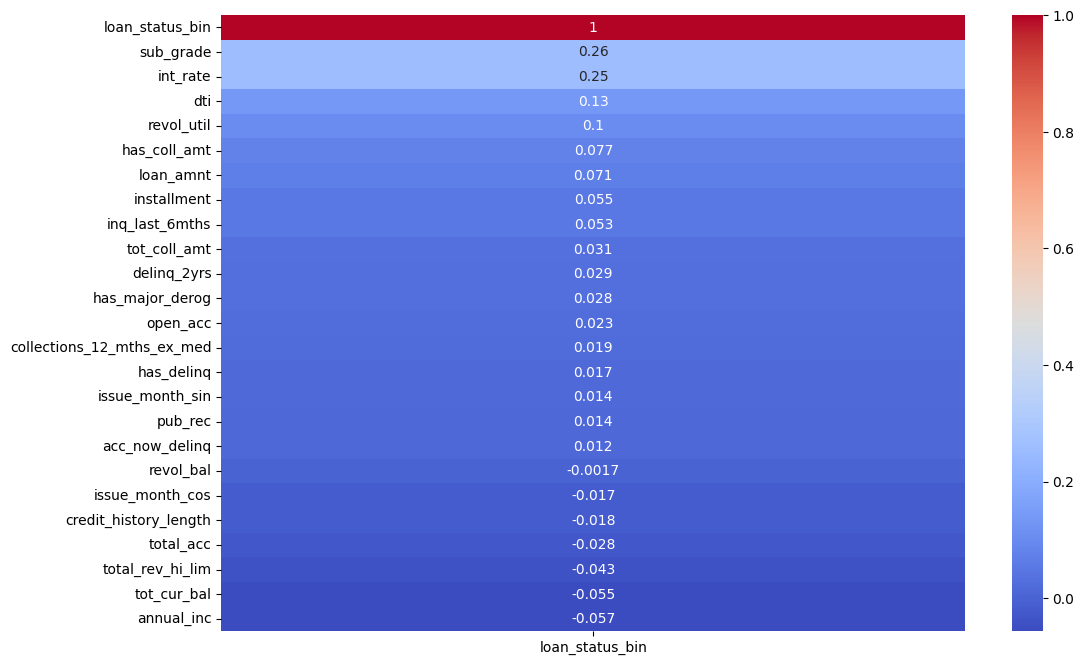

In [68]:
plt.figure(figsize=(12, 8))
sns.heatmap(loan_df_eda.corr(numeric_only=True)[['loan_status_bin']].sort_values(by='loan_status_bin', ascending=False), annot=True, cmap='coolwarm')

Sub-grade e Interest rate tienen las mayores correlaciones con la variable objetivo

**Datos Geográficos**

addr_state: mapa de calor o gráfico de barras con proporción de incumplimientos por estado.

In [69]:
loan_df_eda.groupby('addr_state')['loan_status_bin'].mean().sort_values(ascending=False)

addr_state
MS    0.311609
TN    0.293896
IN    0.276504
NE    0.274510
NV    0.262295
AL    0.250224
OK    0.247490
FL    0.244012
NY    0.238256
NM    0.237057
LA    0.235912
AR    0.234820
HI    0.234246
MI    0.232890
MO    0.231649
NC    0.230979
IA    0.230769
OH    0.230657
PA    0.229424
NJ    0.228995
KY    0.228012
MD    0.226683
SD    0.222603
RI    0.221552
VA    0.221379
DE    0.221300
MN    0.219108
AZ    0.215239
WI    0.213045
GA    0.208927
CA    0.205074
MA    0.203809
IL    0.202001
TX    0.200282
UT    0.199369
KS    0.199265
WA    0.198156
SC    0.197439
CT    0.196958
VT    0.193258
OR    0.192837
AK    0.185449
MT    0.185372
WV    0.183775
CO    0.173302
NH    0.164030
WY    0.162939
DC    0.125290
ID    0.111111
ND    0.111111
ME    0.000000
Name: loan_status_bin, dtype: float64

Los estados Mississippi (MS), Tennessee (TN), Indiana (IN), Nebraska (NE), Nevada (NV) y Alabama (AL) presentan las tasas más altas de morosidad en el conjunto de datos analizado, con valores que van desde aproximadamente el 31.2% en MS hasta el 25.0% en AL.

**Datos temporales**

issue_month_sin y issue_month_cos: usar scatterplots para ver distribución mensual e incidencia de impagos a lo largo del año.

In [70]:
cyclic = ['issue_month_sin', 'issue_month_cos']

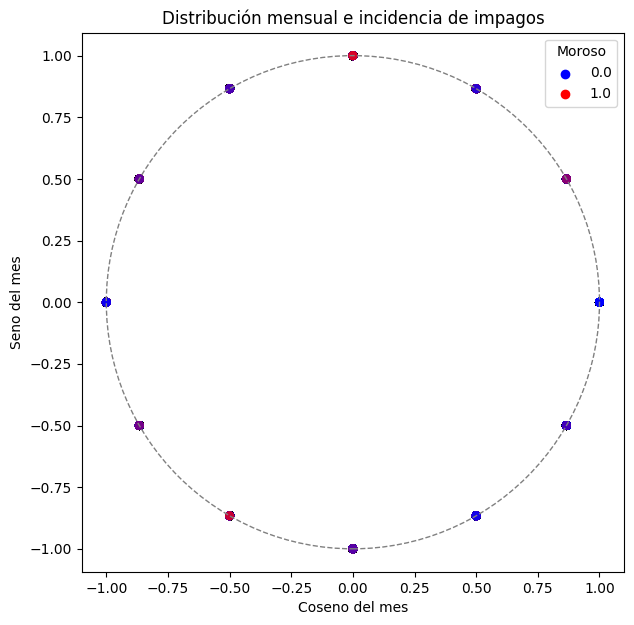

In [71]:
plt.figure(figsize=(7,7))

sns.scatterplot(
    data=loan_df_eda,
    x='issue_month_cos',
    y='issue_month_sin',
    hue='loan_status_bin',
    alpha=0.5,
    palette={0: 'blue', 1: 'red'},
    edgecolor=None
)

plt.title('Distribución mensual e incidencia de impagos')
plt.xlabel('Coseno del mes')
plt.ylabel('Seno del mes')

# Opcional: dibujar círculo unitario para contexto
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

plt.legend(title='Moroso')
plt.axis('equal')
plt.show()

Text(0, 0.5, 'Tasa de impago')

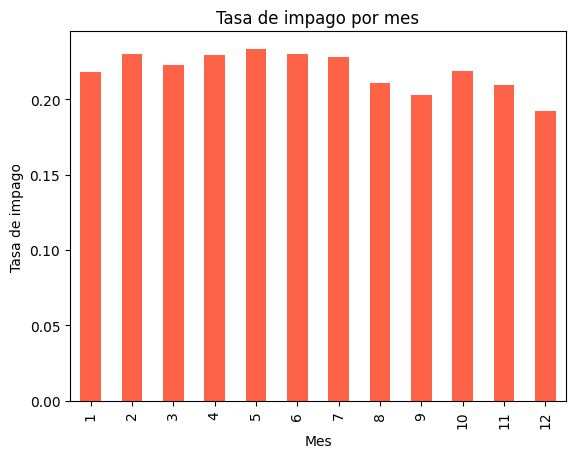

In [72]:
loan_df_eda['issue_month'] = (
    np.arctan2(loan_df_eda['issue_month_sin'], loan_df_eda['issue_month_cos']) * 12 / (2*np.pi)
).mod(12).round().astype(int).replace({0: 12})

monthly_rate = loan_df_eda.groupby('issue_month')['loan_status_bin'].mean()

monthly_rate.plot(kind='bar', color='tomato')
plt.title('Tasa de impago por mes')
plt.xlabel('Mes')
plt.ylabel('Tasa de impago')

### Encoding de variables categóricas

In [73]:
loan_df_encoded = loan_df_clean_categorical.copy()

In [74]:
loan_df_encoded.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,...,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,issue_month_sin,issue_month_cos,credit_history_length,has_major_derog,has_delinq,has_coll_amt,loan_status_bin
0,5000.0,36 months,10.65,162.87,6,10+ years,RENT,24000.0,Verified,credit_card,...,0,80509.0,23700.0,-2.449294e-16,1.0,26.931507,0,0,0,0.0
1,2500.0,60 months,15.27,59.83,13,< 1 year,RENT,30000.0,Source Verified,car,...,0,80509.0,23700.0,-2.449294e-16,1.0,12.676712,0,0,0,1.0
2,2400.0,36 months,15.96,84.33,14,10+ years,RENT,12252.0,Not Verified,small_business,...,0,80509.0,23700.0,-2.449294e-16,1.0,10.087671,0,0,0,0.0
3,10000.0,36 months,13.49,339.31,10,10+ years,RENT,49200.0,Source Verified,other,...,0,80509.0,23700.0,-2.449294e-16,1.0,15.841096,0,1,0,0.0
5,5000.0,36 months,7.90,156.46,3,3 years,RENT,36000.0,Source Verified,wedding,...,0,80509.0,23700.0,-2.449294e-16,1.0,7.084932,0,0,0,0.0


In [75]:
loan_df_encoded.select_dtypes(include='object').head()

,term,emp_length,home_ownership,verification_status,purpose,addr_state,initial_list_status
0,36 months,10+ years,RENT,Verified,credit_card,AZ,f
1,60 months,< 1 year,RENT,Source Verified,car,GA,f
2,36 months,10+ years,RENT,Not Verified,small_business,IL,f
3,36 months,10+ years,RENT,Source Verified,other,CA,f
5,36 months,3 years,RENT,Source Verified,wedding,AZ,f


In [76]:
# Definimos las columnas categóricas
categorical_columns = [
    'term',
    'emp_length',
    'home_ownership',
    'verification_status',
    'purpose',
    'addr_state',
    'initial_list_status'
]

# Aplicamos One-Hot Encoding (manteniendo todas las categorías)
loan_df_encoded = pd.get_dummies(loan_df_encoded, columns=categorical_columns, drop_first=True)

# El profesor en clase usa un encoder personalizado

### Normalización

In [77]:
loan_df_normalized = loan_df_encoded.copy()

In [78]:
loan_df_normalized.shape

(268277, 108)

In [79]:
loan_df_normalized.select_dtypes(include='float')

,loan_amnt,int_rate,installment,annual_inc,dti,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,tot_cur_bal,total_rev_hi_lim,issue_month_sin,issue_month_cos,credit_history_length,loan_status_bin
0,5000.0,10.65,162.87,24000.0,27.65,1.0,3.0,13648.0,83.7,9.0,80509.0,23700.0,-2.449294e-16,1.000000,26.931507,0.0
1,2500.0,15.27,59.83,30000.0,1.00,5.0,3.0,1687.0,9.4,4.0,80509.0,23700.0,-2.449294e-16,1.000000,12.676712,1.0
2,2400.0,15.96,84.33,12252.0,8.72,2.0,2.0,2956.0,98.5,10.0,80509.0,23700.0,-2.449294e-16,1.000000,10.087671,0.0
3,10000.0,13.49,339.31,49200.0,20.00,1.0,10.0,5598.0,21.0,37.0,80509.0,23700.0,-2.449294e-16,1.000000,15.841096,0.0
5,5000.0,7.90,156.46,36000.0,11.20,3.0,9.0,7963.0,28.3,12.0,80509.0,23700.0,-2.449294e-16,1.000000,7.084932,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887351,4200.0,15.99,147.64,48000.0,36.93,0.0,13.0,12943.0,63.4,45.0,207975.0,20400.0,5.000000e-01,0.866025,24.435616,1.0
887364,10775.0,6.03,327.95,54000.0,13.22,0.0,9.0,10776.0,25.8,21.0,24696.0,41700.0,5.000000e-01,0.866025,39.194521,0.0
887366,6225.0,16.49,220.37,27000.0,18.58,1.0,3.0,1756.0,97.6,4.0,8357.0,1800.0,5.000000e-01,0.866025,3.917808,0.0
887369,4000.0,8.67,126.59,50000.0,12.63,0.0,11.0,1700.0,5.6,30.0,18979.0,30100.0,5.000000e-01,0.866025,12.342466,0.0


In [80]:
# Seleccionar solo columnas float para escalar
float_cols = loan_df_normalized.select_dtypes(include='float').columns

# Escalar variables continuas normales con MinMaxScaler
scaler_minmax = MinMaxScaler()
loan_df_normalized[continuas] = scaler_minmax.fit_transform(loan_df_normalized[continuas])

# Escalar variables con sesgo o outliers con RobustScaler
scaler_robust = RobustScaler()
loan_df_normalized[continuas_biased] = scaler_robust.fit_transform(loan_df_normalized[continuas_biased])

loan_df_normalized[['sub_grade']] = MinMaxScaler().fit_transform(loan_df_normalized[['sub_grade']])

### Selección de conjuntos de Entrenamiento y Validación

In [81]:
loan_df_training = loan_df_normalized.copy()

In [82]:
loan_df_training.head()

,loan_amnt,int_rate,installment,sub_grade,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w
0,0.130435,0.225180,0.104479,0.176471,-0.904762,0.691423,0,0.0,0.026667,0,...,False,False,False,False,False,False,False,False,False,False
1,0.057971,0.420363,0.031344,0.382353,-0.761905,0.025006,0,4.0,0.026667,0,...,False,False,False,False,False,False,False,False,False,False
2,0.055072,0.449514,0.048733,0.411765,-1.184476,0.218055,0,1.0,0.013333,0,...,False,False,False,False,False,False,False,False,False,False
3,0.275362,0.345163,0.229711,0.294118,-0.304762,0.500125,0,0.0,0.120000,0,...,False,False,False,False,False,False,False,False,False,False
5,0.130435,0.108999,0.099929,0.088235,-0.619048,0.280070,0,2.0,0.106667,0,...,False,False,False,False,False,False,False,False,False,False


**Ojo: Las clases de loan_status_bin tienen mucho desbalance, entonces hay que hacer algo aquí antes de entrenar**

In [83]:
X = loan_df_training.drop(columns=['loan_status_bin'])
y = loan_df_training['loan_status_bin']

# Guardar localmente para el backend de la app web
X.to_csv("X.csv", index=False)
y.to_csv("y.csv", index=False)

# Split estratificado: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=1977,
    stratify=y  # mantiene proporción de clases
)

# Confirmar tamaños
print(f'Tamaño train: {X_train.shape}, Tamaño test: {X_test.shape}')
print(f'Proporción en train:\n{y_train.value_counts(normalize=True)}')
print(f'Proporción en test:\n{y_test.value_counts(normalize=True)}')

Tamaño train: (214621, 107), Tamaño test: (53656, 107)
Proporción en train:
loan_status_bin
0.0    0.780995
1.0    0.219005
Name: proportion, dtype: float64
Proporción en test:
loan_status_bin
0.0    0.780994
1.0    0.219006
Name: proportion, dtype: float64


# Entrenamiento de modelos

## Log Reg - Modelo 0

La regresión logística es ideal como modelo baseline porque:

- Es interpretable: Permite entender el impacto de cada variable en la probabilidad.

- Rápido y eficiente: Requiere menos recursos computacionales que una red neuronal.

- Funciona bien en problemas de clasificación binaria (como predecir si un cliente incumplirá o no).

In [84]:
# Modelo con pesos balanceados
# logreg_balanced = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
# logreg_balanced.fit(X_train, y_train)
# y_pred_balanced = logreg_balanced.predict(X_test)

# Métricas
# print("=== Balanceo con class_weight ===")
# print(classification_report(y_test, y_pred_balanced))
# print("AUC-ROC:", roc_auc_score(y_test, logreg_balanced.predict_proba(X_test)[:, 1]))

El modelo base logra una AUC-ROC de **0.708**, lo cual indica una capacidad moderada para discriminar entre préstamos cumplidos e incumplidos. Aunque la precisión sobre la clase incumplida (1.0) es baja (0.35), el **recall alcanza 0.64**, lo que sugiere que el modelo logra capturar correctamente una fracción importante de los incumplimientos.

Esto es clave en contextos financieros donde los **falsos negativos (no detectar un incumplimiento)** pueden tener consecuencias graves. No obstante, el desempeño global aún es limitado, lo que justifica la exploración de modelos más expresivos como redes neuronales artificiales en la siguiente sección.

Veamos si ahora podemos mejorar las métricas usando un modelo que se ajuste mejor a los datos que tenemos.

Empecemos por un modelo simple y vamos mejorando cosas según veamos cual es el problema.

Reto
1. Cree y valide un modelo de probabilidad de incumplimiento basado en redes neuronales artificiales. Optimice la arquitectura del modelo.
2. Represente este modelo con una scorecard
3. Analice qué variables hacen más riesgosa a una persona
4. Cree una app web que le permita saber a las personas, de acuerdo con sus características, cuál es su scorecard y cómo se ve contra la población.

In [85]:
# Calcular pesos de clase usando los datos de entrenamiento
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convertir a diccionario para usar en modelos de Keras
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Pesos de clase:", class_weight_dict)

Pesos de clase: {0.0: 0.640208688804305, 1.0: 2.283056400655277}


In [86]:
def build_model_1(input_dim, learning_rate=0.001):
    model = Sequential([
        Dense(32, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

In [87]:
def train_model(model, X_train, y_train, X_val, y_val, 
                class_weight=None, 
                epochs=50, batch_size=256,
                patience=10):

    early_stop = EarlyStopping(
        monitor='val_auc', patience=patience, mode='max',
        restore_best_weights=True, verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_auc', factor=0.5, patience=patience//2,
        mode='max', verbose=1
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight,
        verbose=2
    )
    
    return model, history

In [88]:
def evaluate_model(model, X_test, y_test):
    results = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {results[0]:.4f} | Test Accuracy: {results[1]:.4f} | Test AUC: {results[2]:.4f}")

    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    print("AUC-ROC (manual):", roc_auc_score(y_test, y_pred_prob))

In [89]:
def plot_history(history):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))
    
    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend(); plt.title('Loss')
    
    # AUC
    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.legend(); plt.title('AUC')
    
    plt.show()

## RNA - Modelo 1 

In [90]:
# model = build_model_1(X_train.shape[1])
# model, history = train_model(model, X_train, y_train, X_test, y_test, 
#                              class_weight=class_weight_dict,
#                              epochs=40, batch_size=256, patience=8)
# evaluate_model(model, X_test, y_test)
# plot_history(history)

El modelo alcanzó un desempeño **competitivo como punto de partida**, con una AUC de validación superior a 0.70 y un buen **recall en la clase minoritaria** (clientes incumplidos), lo cual es deseable en contextos financieros.

##### Limitaciones del modelo base

A pesar de que el modelo base logró métricas aceptables (AUC ≈ 0.713 y recall ≈ 0.64), se identificaron las siguientes **limitaciones** que motivaron la exploración de arquitecturas más complejas y la optimización de hiperparámetros:

- **Capacidad limitada**: la arquitectura poco profunda (solo dos capas ocultas) puede no ser suficiente para capturar interacciones complejas entre las variables.

- **Estancamiento en validación**: la métrica `val_auc` se estabiliza rápidamente y no mejora, lo que sugiere que el modelo alcanza pronto su techo de generalización.

- **Riesgo de alta varianza en datos nuevos**: al tener baja complejidad y pocos parámetros, podría no generalizar bien frente a distribuciones levemente distintas.

- **Desempeño limitado en precisión**: la precisión sobre la clase positiva fue baja (~0.35), indicando una alta tasa de falsos positivos.

- **Sin exploración de hiperparámetros**: los valores de dropout, learning rate y número de neuronas fueron seleccionados manualmente sin validación sistemática, lo que deja espacio para optimización.


## RNA - Modelo 2

In [91]:
def build_model_2(input_dim, learning_rate=0.001):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

In [92]:
# model = build_model_2(X_train.shape[1], learning_rate=0.001)
# model, history = train_model(
#     model, X_train, y_train, X_test, y_test,
#     class_weight=class_weight_dict,
#     batch_size=512,
#     epochs=100,
#     patience=10
# )
# evaluate_model(model, X_test, y_test)
# plot_history(history)

A pesar del entrenamiento prolongado y del incremento en capacidad, el modelo muestra signos de **sobreajuste**: la métrica `val_auc` se estanca e incluso disminuye levemente en las últimas épocas, mientras que `train_auc` continúa creciendo. Esto indica que el modelo está aprendiendo patrones específicos del conjunto de entrenamiento que no generalizan adecuadamente al conjunto de validación.

Además, aunque el **recall para la clase de incumplimiento mejora** (0.58), la **precisión sigue siendo baja** (0.36), lo cual implica una alta tasa de falsos positivos. Esta situación puede llevar a decisiones erróneas en un entorno financiero real.

Por lo tanto, este modelo no se selecciona como definitivo, y se plantea la necesidad de simplificar su arquitectura y realizar una búsqueda controlada de hiperparámetros.


## RNA - Búsqueda de hiperparámetros 

In [93]:
def build_model_final_adapted(
    input_dim,
    n_layers=3,
    n_neurons=[128, 64, 32],
    dropout_rate=0.3,
    l1_reg=1e-6,
    l2_reg=1e-4,
    learning_rate=0.0005,
    activation='relu',
    batch_norm=True
):
    model = Sequential()
    
    # Asegurar estructura decreciente si n_neurons es entero
    if isinstance(n_neurons, int):
        n_neurons = [n_neurons // (2**i) for i in range(n_layers)]
        n_neurons = [max(16, n) for n in n_neurons]
    
    # Capa de entrada
    model.add(Dense(
        n_neurons[0],
        activation=activation,
        input_shape=(input_dim,),
        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
        kernel_initializer='he_normal'
    ))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Capas ocultas adicionales
    for i in range(1, n_layers):
        units = n_neurons[i] if i < len(n_neurons) else max(16, n_neurons[-1] // 2)
        model.add(Dense(
            units,
            activation=activation,
            kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
            kernel_initializer='he_normal'
        ))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Capa de salida
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))

    # Compilar modelo
    model.compile(
        optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

In [94]:
param_grid_final = {
    'n_layers': [3, 4],
    'n_neurons': [
        [128, 64, 32],
        [256, 128, 64], 
        [512, 256, 128]
    ],
    'dropout_rate': [0.3, 0.4],
    'l1_reg': [1e-6],
    'l2_reg': [1e-4],
    'learning_rate': [0.001, 0.0005],
    'activation': ['relu']
}

In [95]:
grid = list(itertools.product(*param_grid_final.values()))
columns = list(param_grid_final.keys())
results = []

```python
for combo in grid:
    config = dict(zip(columns, combo))
    print(f"Entrenando: {config}")
    
    model = build_model_final_adapted(
        input_dim=X_train.shape[1],
        **config
    )
    
    early_stop = EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=5, mode='max', verbose=0)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=256,
        class_weight=class_weight_dict,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    
    y_pred_prob = model.predict(X_test)
    auc_score = roc_auc_score(y_test, y_pred_prob)
    
    results.append({**config, 'auc_test': auc_score})

# ----------------------------------------------------------
# MOSTRAR RESULTADOS
# ----------------------------------------------------------

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='auc_test', ascending=False)
results_df.to_csv("resultados_gridsearch_final.csv", index=False)
print(results_df.head())
```

In [96]:
print("Mejor modelo")

Mejor modelo


## RNA - Modelo Final

In [97]:
def build_model_final_definitivo(input_dim):
    model = Sequential()
    
    # Capa de entrada
    model.add(Dense(128, activation='relu', input_shape=(input_dim,),
                    kernel_regularizer=l1_l2(l1=1e-6, l2=1e-4),
                    kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    # Capa oculta 1
    model.add(Dense(64, activation='relu',
                    kernel_regularizer=l1_l2(l1=1e-6, l2=1e-4),
                    kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    # Capa oculta 2
    model.add(Dense(32, activation='relu',
                    kernel_regularizer=l1_l2(l1=1e-6, l2=1e-4),
                    kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    # Capa de salida
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))
    
    # Compilar modelo
    model.compile(
        optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

```python
model_final = build_model_final_definitivo(X_train.shape[1])

early_stop = EarlyStopping(monitor='val_auc', patience=15, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=7, mode='max')

history_final = model_final.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=256,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
```

In [98]:
# model_final.save("modelo_riesgo_crediticio_final.h5")

# Análisis de resultados del modelo

In [99]:
# Ruta al archivo en la carpeta de input
ruta_modelo = "/kaggle/input/modelo-riesgo-crediticio/tensorflow2/default/1/modelo_riesgo_crediticio_final.h5"

# Cargar el modelo final
model_final = load_model(ruta_modelo)

I0000 00:00:1749324564.746420      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [100]:
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Evolución de la función de pérdida")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.legend()

    # AUC
    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title("Evolución del AUC")
    plt.xlabel("Épocas")
    plt.ylabel("AUC")
    plt.legend()

    plt.tight_layout()
    plt.show()

# plot_training_history(history_final)

I0000 00:00:1749324566.631255      61 service.cc:148] XLA service 0x7da5ec003070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749324566.631829      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749324566.725567      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


 127/1677 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

I0000 00:00:1749324567.009848      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1677/1677 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


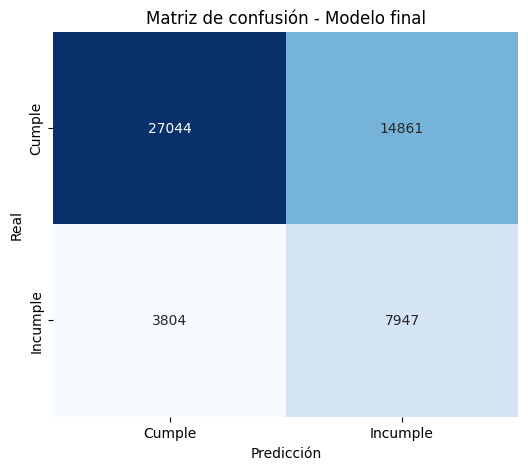

In [101]:
y_pred_prob = model_final.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Cumple', 'Incumple'],
            yticklabels=['Cumple', 'Incumple'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - Modelo final")
plt.show()

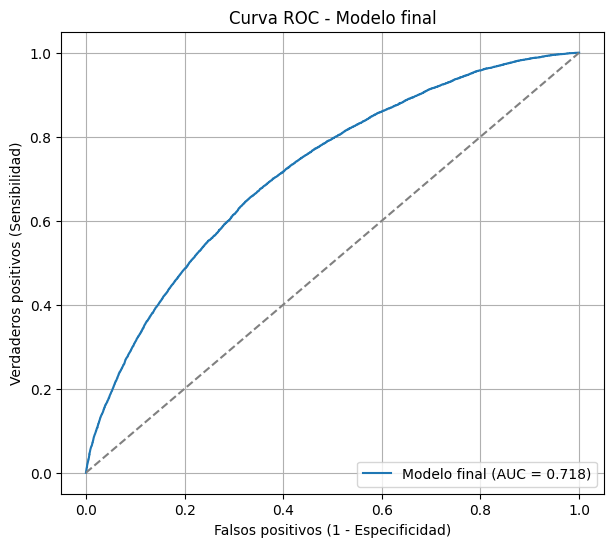

In [102]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'Modelo final (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("Falsos positivos (1 - Especificidad)")
plt.ylabel("Verdaderos positivos (Sensibilidad)")
plt.title("Curva ROC - Modelo final")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

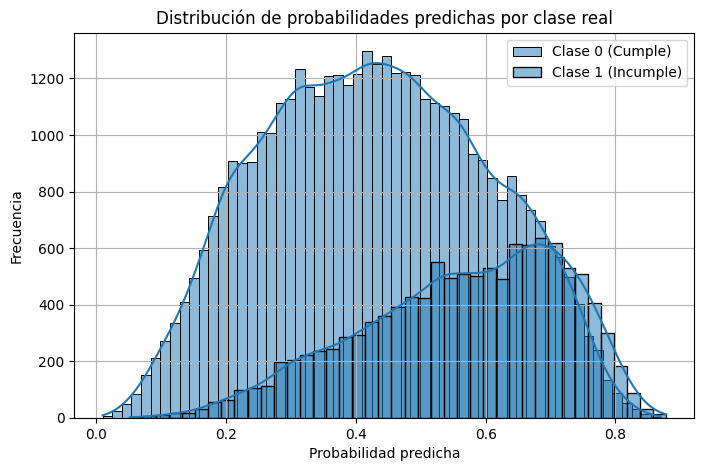

In [103]:
plt.figure(figsize=(8,5))
sns.histplot(y_pred_prob[y_test==0], label='Clase 0 (Cumple)', color='blue', kde=True)
sns.histplot(y_pred_prob[y_test==1], label='Clase 1 (Incumple)', color='red', kde=True)
plt.xlabel("Probabilidad predicha")
plt.ylabel("Frecuencia")
plt.title("Distribución de probabilidades predichas por clase real")
plt.legend()
plt.grid(True)
plt.show()

El modelo final se entrenó con la mejor configuración obtenida a partir de una búsqueda exhaustiva de hiperparámetros. A continuación, se resumen sus resultados clave:

- **Accuracy**: 65%
- **AUC-ROC**: 0.718
- **Recall (clase 1)**: 0.68
- **Precisión (clase 1)**: 0.35
- **F1-score (clase 1)**: 0.46

Estos resultados reflejan un equilibrio razonable entre la identificación de clientes en riesgo y la generación de falsos positivos. La red fue entrenada utilizando `class_weight`, regularización `L1` y `L2`, `Dropout`, `BatchNormalization` y optimización con Adam + ReduceLROnPlateau.